In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline
from gensim.models import Word2Vec
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph 
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel,delayed
from tqdm import tqdm

In [34]:
metapaths = [
    ["author", "paper", "author"],
    ["author", "paper", "term", "paper", "author"],
    ["author", "paper", "conf", "paper", "author"],
]

walk_length = 64
num_walks_per_node = 25
emb_dim = 128

model_save_path = 'model_save_dir'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
model_save_path = os.path.join(model_save_path,'DBLP')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    
    
model_use_data_DIR = 'model_use_data'
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
model_use_data_DIR = os.path.join(model_use_data_DIR,'DBLP')
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
    
walk_length = 64
num_walks_per_node = 25
emb_dim = 128
emb_fpath = os.path.join(model_save_path, 'mp2v_{}_{}_{}.npy'.format(emb_dim,num_walks_per_node,walk_length))



In [9]:
src_dir = './../../dblp/processed_data/DBLP/'

nodes_author_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_author.csv'),
    index_col = 0
)
nodes_paper_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_paper.csv'),
    index_col = 0
)
nodes_term_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_term.csv'),
    index_col = 0
)
nodes_conf_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_conf.csv'),
    index_col = 0
)


fpath_list = ['PT_edges.csv','PC_edges.csv','PA_edges.csv']
df_edges = None
for fpath in fpath_list:
    _df = pd.read_csv( os.path.join(src_dir,fpath), index_col = None )
    if df_edges is None : df_edges = _df
    else:
        df_edges = df_edges.append(_df,ignore_index= True)


In [11]:

graph_obj = StellarGraph({
    "author": nodes_author_df, 
    "paper":nodes_paper_df,
    "term": nodes_term_df,
    "conf": nodes_conf_df
},
    df_edges
)

In [ ]:

# walks = rw.run(
#     nodes=list(g.nodes()),  # root nodes
#     length=walk_length,  # maximum length of a random walk
#     n=1,  # number of random walks per root node
#     metapaths=metapaths,  # the metapaths
# )



In [19]:
def generate_random_walks(graph_obj , num_walks_per_node, walk_length, metapaths):
    random_walk_object = UniformRandomMetaPathWalk(graph_obj)
    cpu_count = multiprocessing.cpu_count()
    list_nodes = list(graph_obj.nodes())
    num_chunks = cpu_count
    chunk_len = (len(list_nodes)//num_chunks)
    chunks = [list_nodes[i*chunk_len: (i+1)*chunk_len ] for i in range(0, num_chunks+1)]
    
    res =  Parallel(n_jobs=cpu_count)(
        delayed(aux_gen_walks)(
            node_chunk, walk_length, random_walk_object, metapaths, num_walks_per_node 
        ) 
        for node_chunk in chunks
    )
    
    all_walks = []
    for r in res:
        all_walks.extend(r)
    return all_walks

def aux_gen_walks(
    node_chunk, 
    walk_length, 
    random_walk_object,
    metapaths = None,
    num_walks = 1
):
    walks = random_walk_object.run(
        nodes=node_chunk,
        length=walk_length,
        n=num_walks,
        metapaths=metapaths
    )
    return walks

In [20]:

walks_save_file = "mp2v_random_walks_{}_{}.npy".format(walk_length, num_walks_per_node)
walks_save_file = os.path.join(model_use_data_DIR, walks_save_file)
try:
    walks_np_arr = np.load( walks_save_file )
    walks = [ list(_) for _ in walks_np_arr]
except:
    walks = generate_random_walks(graph_obj, num_walks_per_node, walk_length, metapaths)
    walks_np_arr = np.array(walks)
    np.save( walks_save_file, walks_np_arr)

print("Number of random walks: {}".format(len(walks)))


Number of random walks: 304275


In [22]:
str_walks = [[str(n) for n in walk] for walk in walks]

In [28]:
if not os.path.exists(emb_fpath):
    
    word2vec_params = {
       'sg': 0, 
       "size": emb_dim,
       "alpha": 0.5,
       "min_alpha": 0.001,
       'window':5,
       'min_count': 0,
       "workers": multiprocessing.cpu_count(),
       "negative": 1,
       "hs": 0,  # 0: negative sampling, 1:hierarchical  softmax
       'compute_loss': True,
       'iter': 10,
       'cbow_mean':1,
    }

    iters = 20
    mp2v_model = Word2Vec(**word2vec_params)
    mp2v_model.build_vocab(str_walks)
    losses = []
    learning_rate = 0.5
    step_size = (0.5 - 0.001) / iters
    
    
    for i in tqdm(range(iters)):
        trained_word_count, raw_word_count = mp2v_model.train(
            str_walks, 
            compute_loss=True,
            start_alpha=learning_rate,
            end_alpha=learning_rate,
            total_examples=mp2v_model.corpus_count,
            epochs=1
        )
        loss = mp2v_model.get_latest_training_loss()
        losses.append(loss)
        print('>> ', i, ' Loss:: ', loss, learning_rate)
        learning_rate -= step_size
    
    # ======== Save node weights ============ #
    node_embeddings = []
    for i in range(len(graph_obj.nodes())):
        vec = mp2v_model.wv[str(i)]
        node_embeddings.append(vec)

    node_embeddings = np.array(node_embeddings)
    np.save(emb_fpath, node_embeddings )
else:
    node_embeddings =  np.load(emb_fpath)
    

  5%|▌         | 1/20 [00:17<05:31, 17.43s/it]

>>  0  Loss::  25450.29296875 0.5


 10%|█         | 2/20 [00:35<05:16, 17.60s/it]

>>  1  Loss::  2362.20654296875 0.47505


 15%|█▌        | 3/20 [00:53<05:02, 17.77s/it]

>>  2  Loss::  1380.3836669921875 0.45009999999999994


 20%|██        | 4/20 [01:12<04:47, 17.98s/it]

>>  3  Loss::  1059.244873046875 0.4251499999999999


 25%|██▌       | 5/20 [01:30<04:31, 18.10s/it]

>>  4  Loss::  982.130126953125 0.4001999999999999


 30%|███       | 6/20 [01:49<04:15, 18.25s/it]

>>  5  Loss::  747.1292114257812 0.37524999999999986


 35%|███▌      | 7/20 [02:07<03:58, 18.36s/it]

>>  6  Loss::  653.6107177734375 0.35029999999999983


 40%|████      | 8/20 [02:26<03:41, 18.45s/it]

>>  7  Loss::  411.4996337890625 0.3253499999999998


 45%|████▌     | 9/20 [02:44<03:23, 18.47s/it]

>>  8  Loss::  556.478515625 0.3003999999999998


 50%|█████     | 10/20 [03:03<03:05, 18.55s/it]

>>  9  Loss::  483.5340576171875 0.27544999999999975


 55%|█████▌    | 11/20 [03:21<02:46, 18.48s/it]

>>  10  Loss::  445.7109069824219 0.2504999999999997


 60%|██████    | 12/20 [03:40<02:28, 18.51s/it]

>>  11  Loss::  456.0545349121094 0.22554999999999972


 65%|██████▌   | 13/20 [03:58<02:09, 18.49s/it]

>>  12  Loss::  425.03863525390625 0.20059999999999972


 70%|███████   | 14/20 [04:17<01:51, 18.51s/it]

>>  13  Loss::  338.6337585449219 0.17564999999999972


 75%|███████▌  | 15/20 [04:35<01:32, 18.51s/it]

>>  14  Loss::  390.9293212890625 0.15069999999999972


 80%|████████  | 16/20 [04:54<01:13, 18.47s/it]

>>  15  Loss::  374.4370422363281 0.12574999999999972


 85%|████████▌ | 17/20 [05:13<00:55, 18.52s/it]

>>  16  Loss::  375.4394836425781 0.10079999999999972


 90%|█████████ | 18/20 [05:31<00:37, 18.51s/it]

>>  17  Loss::  427.71270751953125 0.07584999999999972


 95%|█████████▌| 19/20 [05:49<00:18, 18.48s/it]

>>  18  Loss::  406.60382080078125 0.05089999999999972


100%|██████████| 20/20 [06:08<00:00, 18.42s/it]

>>  19  Loss::  380.2527160644531 0.025949999999999723


In [31]:
tsne = TSNE(
    n_components=2, 
    perplexity = 30.0, 
    early_exaggeration=25.0, 
    learning_rate=250
)
node_embeddings_2d = tsne.fit_transform(node_embeddings, )

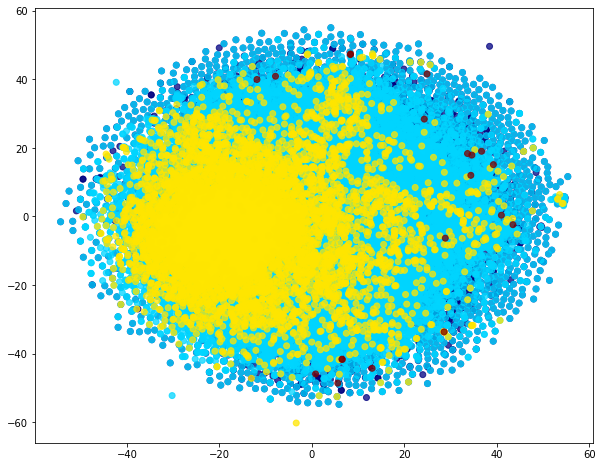

In [33]:
l = 0
node_ids = []
labels = []
df_list = [ nodes_author_df, nodes_paper_df, nodes_term_df, nodes_conf_df]

for _df in df_list:
    _df = _df.reset_index()
    col = list(_df.columns)[0]
    k = list(_df[col])
    node_ids.extend(k)
    labels.extend([l]*len(_df))
    l+=1


plt.figure(figsize=(10, 8))

node_colours = labels
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=0.75,
)
plt.show()